In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [2]:
data=pd.read_excel("bike.xlsx",sheet_name='orders',parse_dates=["order.date"])
print(data.head())
data.info()#a

   order.id  order.line order.date  customer.id  product.id  quantity
0         1           1 2011-01-07            2          48         1
1         1           2 2011-01-07            2          52         1
2         2           1 2011-01-10           10          76         1
3         2           2 2011-01-10           10          52         1
4         3           1 2011-01-10            6           2         1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15644 entries, 0 to 15643
Data columns (total 6 columns):
order.id       15644 non-null int64
order.line     15644 non-null int64
order.date     15644 non-null datetime64[ns]
customer.id    15644 non-null int64
product.id     15644 non-null int64
quantity       15644 non-null int64
dtypes: datetime64[ns](1), int64(5)
memory usage: 733.4 KB


As we see there is no any NAs in our dataframe.

<h1>Descriptive statistics</h1>


In [3]:
print(data.groupby('customer.id')['quantity'].sum().sort_values(ascending=False).head())
data.groupby('customer.id')['quantity'].sum().sort_values(ascending=False).tail()

customer.id
10    3471
8     2301
16    1419
2     1264
13    1155
Name: quantity, dtype: int64


customer.id
23    245
12    234
30    206
27    186
21    128
Name: quantity, dtype: int64

<p>We see top 5 customers and customers who bought the least cbycicles.</p>

In [4]:
datee=data.set_index("order.date")
def season(i):
    spring = range(3, 6)
    summer = range(6, 9)
    fall = range(9, 12)
    #winter anything else
    if i.month  in spring:
        return 'Spring'
    elif i.month  in summer:
        return 'Summer'
    elif i.month  in  fall:
        return "Fall"
    else:
        return "Winter"

datee["Season"]=datee.index.map(season)
        
print(datee.resample("A")['quantity'].sum())
datee.groupby('Season')['quantity'].sum()


order.date
2011-12-31    3268
2012-12-31    3443
2013-12-31    4739
2014-12-31    3947
2015-12-31    4775
Freq: A-DEC, Name: quantity, dtype: int64


Season
Fall      4108
Spring    6594
Summer    5977
Winter    3493
Name: quantity, dtype: int64

Here is bycicles sold per year. And as you can expect in winter bike sales orders decreaseing while eventually in spring it is increasing dramatically

As you can expect in winter bike sales decreaseing while eventually in spring it  is increasing dramatically

In [5]:
datee.head()

,order.id,order.line,customer.id,product.id,quantity,Season
order.date,,,,,,
2011-01-07,1,1,2,48,1,Winter
2011-01-07,1,2,2,52,1,Winter
2011-01-10,2,1,10,76,1,Winter
2011-01-10,2,2,10,52,1,Winter
2011-01-10,3,1,6,2,1,Winter


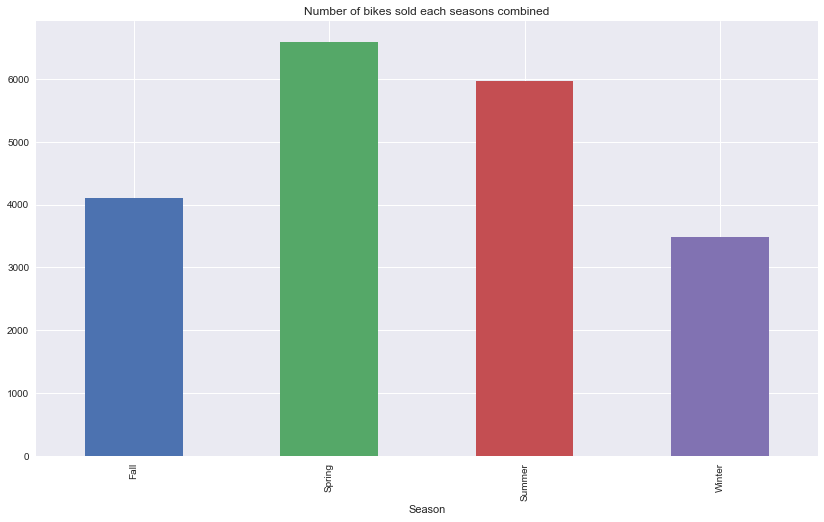

In [7]:
sns.set()
datee.groupby('Season')['quantity'].sum().plot(kind='bar',figsize=(14,8),
                                    title="Number of bikes sold each seasons combined")

# K-Means

<h2>1. Transform the dataset to an applicable data for analysis representing customers in each row, products
(bikes) in column and quantities bought as values</h2>

In [8]:
#alternative 1 read it from excel
pivot_table=pd.read_excel("bike.xlsx",sheet_name="pivot")
pivot_table.head()

,Customers,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,1,3,3,1,5,6,2,4,1,1,...,3,3,3,1,4,6,5,1,0,2
1,2,10,13,11,11,7,11,10,1,0,...,6,10,18,13,11,6,8,6,6,7
2,3,1,3,4,4,4,3,7,0,3,...,1,1,1,2,0,0,0,1,0,1
3,4,2,0,0,3,1,1,3,2,5,...,7,5,4,6,4,9,3,4,4,3
4,5,10,7,3,4,6,3,7,1,3,...,0,0,1,1,1,0,0,0,0,0


<h4>But I prefer to do it in python with pd.pivot_table method</h4> 

In [9]:
piv_table=data.pivot_table(index="customer.id",columns="product.id",values="quantity",aggfunc='count',fill_value=0)
piv_table.head()

product.id,1,2,3,4,5,6,7,8,9,10,...,88,89,90,91,92,93,94,95,96,97
customer.id,,,,,,,,,,,,,,,,,,,,,
1,3,3,1,5,6,2,4,1,1,0,...,3,3,3,1,4,6,5,1,0,2
2,10,13,11,11,7,11,10,1,0,1,...,6,10,18,13,11,6,8,6,6,7
3,1,3,4,4,4,3,7,0,3,4,...,1,1,1,2,0,0,0,1,0,1
4,2,0,0,3,1,1,3,2,5,2,...,7,5,4,6,4,9,3,4,4,3
5,10,7,3,4,6,3,7,1,3,6,...,0,0,1,1,1,0,0,0,0,0


In [10]:
del piv_table.columns.name
piv_table.head()

,1,2,3,4,5,6,7,8,9,10,...,88,89,90,91,92,93,94,95,96,97
customer.id,,,,,,,,,,,,,,,,,,,,,
1,3,3,1,5,6,2,4,1,1,0,...,3,3,3,1,4,6,5,1,0,2
2,10,13,11,11,7,11,10,1,0,1,...,6,10,18,13,11,6,8,6,6,7
3,1,3,4,4,4,3,7,0,3,4,...,1,1,1,2,0,0,0,1,0,1
4,2,0,0,3,1,1,3,2,5,2,...,7,5,4,6,4,9,3,4,4,3
5,10,7,3,4,6,3,7,1,3,6,...,0,0,1,1,1,0,0,0,0,0


<h2>2. Run k-means algorithm and create optimal number of clusters of customers, save the modified data to
an excel file.</h2>
#### Extracting train part from the data without column customer.id
<p> Choosing number of groups is prior experience but good practice is to use Elbow method or Silhouette method to find optimal k</p>

In [11]:
piv_table=piv_table.reset_index()
train=piv_table.iloc[:,1:]
train.head()

,1,2,3,4,5,6,7,8,9,10,...,88,89,90,91,92,93,94,95,96,97
0,3,3,1,5,6,2,4,1,1,0,...,3,3,3,1,4,6,5,1,0,2
1,10,13,11,11,7,11,10,1,0,1,...,6,10,18,13,11,6,8,6,6,7
2,1,3,4,4,4,3,7,0,3,4,...,1,1,1,2,0,0,0,1,0,1
3,2,0,0,3,1,1,3,2,5,2,...,7,5,4,6,4,9,3,4,4,3
4,10,7,3,4,6,3,7,1,3,6,...,0,0,1,1,1,0,0,0,0,0


In [12]:
np.random.seed(42)
SSE={}
for i in range(2,10):
    cluster_try=KMeans(i)
    cluster_try.fit_predict(train)
    SSE[i]=[cluster_try.inertia_,silhouette_score(train,cluster_try.labels_,metric='euclidean')]
SSE

{2: [49650.142857142855, 0.7562387361982662],
 3: [35685.66666666667, 0.4370187871254986],
 4: [25565.413043478264, 0.46108535765610165],
 5: [17552.413043478264, 0.4428614207752469],
 6: [14238.140350877193, 0.26672762140985995],
 7: [11037.833333333332, 0.22029973028305208],
 8: [8856.366666666667, 0.2152153429833446],
 9: [7569.166666666668, 0.21897775637774522]}

Elbow method shows distance of points in its cluster whereas silhouette_score shows fraction of distance from other cluster and its so it should be  big,now plotting both method we will choose appropriate number of cluster.

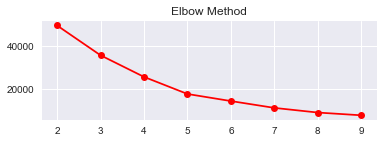

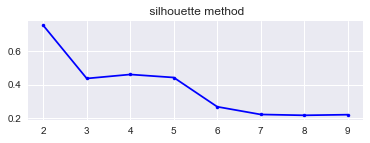

In [13]:
Eblow=[]
Silhout=[]
for key,value in SSE.items():
    Eblow.append(value[0])
    Silhout.append(value[1])


plt.subplot(2,1,1)
plt.plot(SSE.keys(),Eblow,marker='o',color='red')
plt.title("Elbow Method")
plt.show()
plt.subplot(2,1,2)
plt.plot(SSE.keys(),Silhout,marker='.',color='blue')
plt.title(" silhouette method")
plt.show()

From  4 to 5 there is no dramatical change so in both cases so I choose to have 4 cluster.

In [14]:
np.random.seed(423)
cluster= KMeans(4).fit_predict(train)
piv_table['cluster']=cluster

In [15]:
print(piv_table.head())
piv_table.cluster.value_counts()

   customer.id   1   2   3   4  5   6   7  8  9   ...     89  90  91  92  93  \
0            1   3   3   1   5  6   2   4  1  1   ...      3   3   1   4   6   
1            2  10  13  11  11  7  11  10  1  0   ...     10  18  13  11   6   
2            3   1   3   4   4  4   3   7  0  3   ...      1   1   2   0   0   
3            4   2   0   0   3  1   1   3  2  5   ...      5   4   6   4   9   
4            5  10   7   3   4  6   3   7  1  3   ...      0   1   1   1   0   

   94  95  96  97  cluster  
0   5   1   0   2        2  
1   8   6   6   7        0  
2   0   1   0   1        2  
3   3   4   4   3        2  
4   0   0   0   0        2  

[5 rows x 99 columns]


2    23
3     4
1     2
0     1
Name: cluster, dtype: int64

Suprisingly most of peopel were clustered in one group.

In [ ]:
piv_table[['customer.id','cluster']].to_csv("cluster.csv",index=False)

# after merging excel files we get two data.

In [2]:
orders=pd.read_excel('bike.xlsx',sheet_name='orders')
bikes=pd.read_excel("bike.xlsx",sheet_name='bikes')

In [4]:
print(orders.head())
bikes.head()


   order.id  order.line order.date  customer.id  product.id  quantity  \
0       1.0         1.0 2011-01-07          2.0        48.0       1.0   
1       1.0         2.0 2011-01-07          2.0        52.0       1.0   
2       2.0         1.0 2011-01-10         10.0        76.0       1.0   
3       2.0         2.0 2011-01-10         10.0        52.0       1.0   
4       3.0         1.0 2011-01-10          6.0         2.0       1.0   

   Cluster                   Bicycle    price  
0      0.0           Jekyll Carbon 2   6070.0  
1      0.0          Trigger Carbon 2   5970.0  
2      1.0       Beast of the East 1   2770.0  
3      1.0          Trigger Carbon 2   5970.0  
4      2.0  Supersix Evo Hi-Mod Team  10660.0  


,bike.id,model,category1,category2,frame,price
0,1,Supersix Evo Black Inc.,Road,Elite Road,Carbon,12790
1,2,Supersix Evo Hi-Mod Team,Road,Elite Road,Carbon,10660
2,3,Supersix Evo Hi-Mod Dura Ace 1,Road,Elite Road,Carbon,7990
3,4,Supersix Evo Hi-Mod Dura Ace 2,Road,Elite Road,Carbon,5330
4,5,Supersix Evo Hi-Mod Utegra,Road,Elite Road,Carbon,4260


In [4]:
orders.pivot_table(index='Cluster',values=['Bicycle', 'price'],aggfunc={'Bicycle': 'count','price': np.sum})

,Bicycle,price
Cluster,,
0.0,975,4825060.0
1.0,4532,15149520.0
2.0,6881,25334975.0
3.0,3256,9774705.0


as we see clusters 1 and 2  are the customers who are loyal and from who company gets 
the biggest part of total revenue,interest part is there is only one person in cluster 2

In [5]:
orders.groupby(['Cluster','Bicycle'])['quantity'].sum().sort_values(ascending=False)

Cluster  Bicycle                       
2.0      CAAD12 Red                        156.0
         Supersix Evo Ultegra 3            152.0
         Slice Ultegra D12                 147.0
         CAAD8 105                         141.0
         CAAD12 Disc 105                   135.0
         Slice Ultegra                     134.0
         CAAD8 Sora                        133.0
         Trigger Carbon 4                  129.0
         Synapse Carbon Disc 105           129.0
         Synapse Carbon Ultegra 3          126.0
         Slice Hi-Mod Black Inc.           125.0
1.0      Catalyst 2                        124.0
         F-Si Carbon 4                     124.0
2.0      CAAD Disc Ultegra                 123.0
         Synapse Carbon Ultegra 4          123.0
1.0      Trail 5                           122.0
2.0      Synapse Sora                      122.0
         Slice 105                         122.0
         Synapse Disc Tiagra               122.0
         Synapse Disc 105    

#here is bikes sold most and least by each cluster.

In [25]:
bikes.head()

,bike.id,model,category1,category2,frame,price
0,1,Supersix Evo Black Inc.,Road,Elite Road,Carbon,12790
1,2,Supersix Evo Hi-Mod Team,Road,Elite Road,Carbon,10660
2,3,Supersix Evo Hi-Mod Dura Ace 1,Road,Elite Road,Carbon,7990
3,4,Supersix Evo Hi-Mod Dura Ace 2,Road,Elite Road,Carbon,5330
4,5,Supersix Evo Hi-Mod Utegra,Road,Elite Road,Carbon,4260


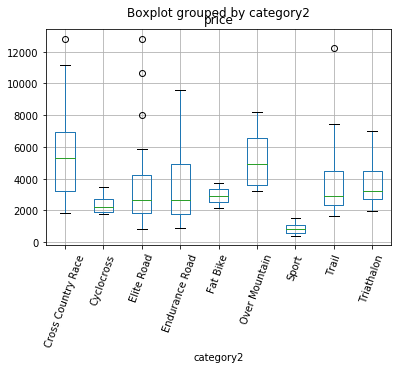

In [34]:
bikes.boxplot('price',by='category2')
plt.xticks(rotation=70)
plt.show()


<h3> In our model  we need categorical variables which are 'category1', 'category2', 'frame' and for better model lets make them as category</h3>

In [19]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 6 columns):
bike.id      97 non-null int64
model        97 non-null object
category1    97 non-null object
category2    97 non-null object
frame        97 non-null object
price        97 non-null int64
dtypes: int64(2), object(4)
memory usage: 4.6+ KB


In [11]:
model2=ols("price ~category1+frame+category2",data=bikes).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     8.598
Date:                Sat, 29 Sep 2018   Prob (F-statistic):           4.16e-09
Time:                        20:02:34   Log-Likelihood:                -878.66
No. Observations:                  97   AIC:                             1777.
Df Residuals:                      87   BIC:                             1803.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    3036.8682    650.336      4.670      0.000    1744.256    4329.481
category1[T.Road]           -1979.5023    520.343     -3.804      0.000   -3013.741    -945.264
frame[T.Carbon]              3609.2503    558.605      6.461      0.000    2498.963    4719.537
category2[T.Cyclocross]     -2251.6162    925.029     -2.434      0.017   -4090.212    -413.021
category2[T.Elite Road]      1093.7054    533.392      2.050      0.043      33.530    2153.881
category2[T.Endurance Road]   -24.9754    548.972     -0.045      0.964   -1116.116    1066.165
category2[T.Fat Bike]        -106.8682   1682.667     -0.064      0.950   -3451.350    3237.614
category2[T.Over Mountain]  -1371.1185    936.609     -1.464      0.147   -3232.730     490.493
category2[T.Sport]          -2155.7571    978.848     -2.202      0.030   -4101.323    -210.191
category2[T.Trail]           -363.5029    814.100     -0.447      0.656   -1981.616    1254.610
category2[T.Triathalon]      -796.6162    843.311     -0.945      0.347   -2472.787     879.555
==============================================================================
Omnibus:                       22.315   Durbin-Watson:                   1.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.574
Skew:                           1.100   Prob(JB):                     2.30e-07
Kurtosis:                       4.650   Cond. No.                     1.32e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.01e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Regression model shows that 
